In [5]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
def polynomial_filter(x, y, window,step_size, polyorder):
    n = window//2
    x_data = []
    y_data = []
    y_model = []
    dy_model = []
    d2y_model = []
    rmse = []
    for i in range(n,int(len(x)),step_size):
        x_range = x[(i-n):(i+n)]
        y_range = y[(i-n):(i+n)]
        coeffs = np.polyfit(x_range, y_range, polyorder)
        ffit = np.poly1d(coeffs)
        fderiv = ffit.deriv()
        fderiv2 = fderiv.deriv()
        ym = np.polyval(ffit, x_range)
        dym = np.polyval(fderiv, x_range)
        d2ym = np.polyval(fderiv2, x_range)
        if i == n:
            for ind in range(0,int(n-step_size),step_size):
                x_data.append(x_range[ind])
                y_data.append(y_range[ind])
                y_model.append(ym[ind])
                dy_model.append(dym[ind])
                d2y_model.append(d2ym[ind])
                rmse.append(np.sqrt(np.mean((ym - y_range)**2)))
        x_data.append(x_range[n])
        y_data.append(y_range[n])
        y_model.append(ym[n])
        dy_model.append(dym[n])
        d2y_model.append(d2ym[n])
        rmse.append(np.sqrt(np.mean((ym-y_range)**2)))        
        if int(len(x_range)) - i < n:
            for ind2 in range(n+step_size,int(n-step_size),step_size):
                x_data.append(x_range[ind2])
                y_data.append(y_range[ind2])
                y_model.append(ym[ind2])
                dy_model.append([dym[ind2]])
                d2y_model.append(d2ym[ind2])
                rmse.append(np.sqrt(np.mean((ym-y_range)**2)))  
        elif int(len(x_range)) - i < n - step_size:
            break

    data = pd.DataFrame()    
    data['x_data'] = pd.Series(data = x_data)
    data['y_data'] = pd.Series(data = y_data)
    data['y_model'] = pd.Series(data = y_model)
    data['dydx'] = pd.Series(data = dy_model)
    data['d2ydx2'] = pd.Series(data = d2y_model)
    data['RMSE'] = pd.Series(data = rmse)
    
    rmse_avg = np.sqrt(np.mean((data['RMSE'])**2))
    avg_error = np.mean(data['RMSE'])

    data['avg_error'] = pd.Series(data=avg_error)
    data['rmse_avg'] = pd.Series(data=rmse_avg)
    data['window'] = pd.Series(data=window)
    data['stepsize'] = pd.Series(step_size)
                
    return data

In [6]:
gitt1 = pd.read_csv('gitt1.csv')

In [7]:
# Cleaning up Kevin's Data

time = np.zeros(len(gitt1['TestTime']))

for i in range(len(gitt1['TestTime'])):
    if '-' not in gitt1['TestTime'][i]:
        hr = float(gitt1['TestTime'][i].split(':')[0]) * 3600
        mins = float(gitt1['TestTime'][i].split(':')[1]) * 60
        sec = float(gitt1['TestTime'][i].split(':')[2])
        time[i] = hr + mins + sec
    if '-' in gitt1['TestTime'][i]:
        #print(gitt1['TestTime'][i].split('-'))
        day = float(gitt1['TestTime'][i].split('-')[0])*86400
        idx2 = gitt1['TestTime'][i].split('-')[1]
        hr = float(idx2.split(':')[0]) * 3600
        mins = float(idx2.split(':')[1]) * 60
        sec = float(idx2.split(':')[2])
        time[i] = day + hr + mins+ sec

In [8]:
gitt1['Time(s)'] = pd.Series(time)

In [9]:
time = np.array(gitt1['Time(s)'])
voltage = np.array(gitt1['Voltage/V'])
current = np.array(gitt1['Current/mA'])

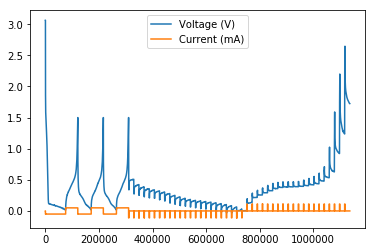

In [10]:
plt.plot(time, voltage, label = 'Voltage (V)')
plt.plot(time, current, label = 'Current (mA)')
plt.legend()
plt.show()

In [11]:
d = {}
workingcurrent = np.argwhere(current != 0)
startidx = int(workingcurrent[0])
cycle = 1

for i in range(len(workingcurrent)-1):
    if workingcurrent[i + 1] - workingcurrent[i] != 1:
        endidx = int(workingcurrent[i +1] - 1)
        d[cycle] = gitt1[startidx:endidx]
        d[cycle] = d[cycle].reset_index(drop = True)
        
        startidx = int(workingcurrent[i +1])
        cycle = cycle + 1
                       

In [12]:
d_relax = {}
dkeys = d.keys()

for key in dkeys:
    mask = d[key]['Current/mA'] == 0
    d_relax[key] = d[key][mask]
    d_relax[key] = d_relax[key].reset_index(drop = True)
    
    d_relax[key]['sqrt_time_diff'] = np.sqrt(d_relax[key]['Time(s)'] - d_relax[key]['Time(s)'][0])

In [13]:
d_trans = {}
dkeys = d.keys()

for key in dkeys:
    mask = d[key]['Current/mA'] != 0
    d_trans[key] = d[key][mask]
    d_trans[key] = d_trans[key].reset_index(drop = True)
    
    d_trans[key]['sqrt_time_diff'] = np.sqrt(d_trans[key]['Time(s)'] - d_trans[key]['Time(s)'][0])

In [87]:
d.keys() # Ignore first key, just full charge/discharge cycles

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

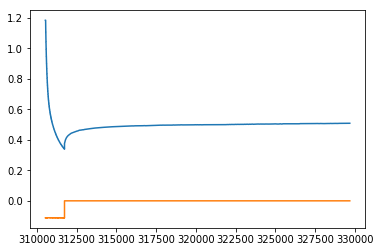

In [88]:
i = 2
plt.plot(d[i]['Time(s)'], d[i]['Voltage/V'])
plt.plot(d[i]['Time(s)'], d[i]['Current/mA'])

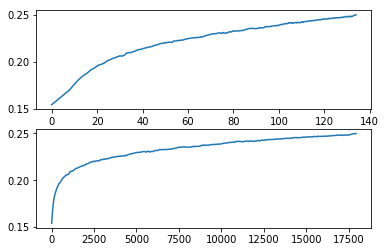

In [166]:
i = 10
fig, ax = plt.subplots(2, 1)
ax[0].plot(d_relax[i]['sqrt_time_diff'], d_relax[i]['Voltage/V'])
ax[1].plot(d_relax[i]['Time(s)']-d_relax[i]['Time(s)'][0], d_relax[i]['Voltage/V'])

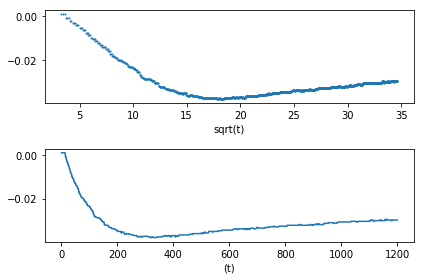

In [222]:
i = 24
fig, ax = plt.subplots(2, 1)
ax[0].plot(d_trans[i]['sqrt_time_diff'][5:], d_trans[i]['Voltage/V'][5:], 'o', markersize = 1)
ax[0].set_xlabel('sqrt(t)')

ax[1].plot(d_trans[i]['Time(s)']-d_trans[i]['Time(s)'][0], d_trans[i]['Voltage/V'])
ax[1].set_xlabel('(t)')

plt.tight_layout()

In [56]:
from scipy.signal import savgol_filter

In [60]:
cycle = 39
homemade = polynomial_filter(x = np.array(d_trans[cycle]['Time(s)']), y = np.array(d_trans[cycle]['Voltage/V']), window = 70, step_size = 1, polyorder = 3)

C:\Users\Victor\Anaconda3\envs\ECStutorial\lib\site-packages\ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app
C:\Users\Victor\Anaconda3\envs\ECStutorial\lib\site-packages\ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app
C:\Users\Victor\Anaconda3\envs\ECStutorial\lib\site-packages\ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app
C:\Users\Victor\Anaconda3\envs\ECStutorial\lib\site-packages\ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app
C:\Users\Victor\Anaconda3\envs\ECStutorial\lib\site-packages\ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app
C:\Users\Victor\Anaconda3\envs\ECStutorial\lib\site-packages\ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly con

In [61]:
homemade.head()

,x_data,y_data,y_model,dydx,d2ydx2,RMSE,avg_error,rmse_avg,window,stepsize
0,1020935.0,0.47,0.458911,0.001999,-0.000026,0.002232,0.000359,0.00051,70.0,1.0
1,1020940.0,0.47,0.468585,0.001871,-0.000026,0.002232,NaN,NaN,NaN,NaN
2,1020941.0,0.47,0.470443,0.001845,-0.000026,0.002232,NaN,NaN,NaN,NaN
3,1020942.0,0.47,0.472276,0.001820,-0.000026,0.002232,NaN,NaN,NaN,NaN
4,1020943.0,0.47,0.474083,0.001794,-0.000026,0.002232,NaN,NaN,NaN,NaN


(-5e-05, 1e-05)

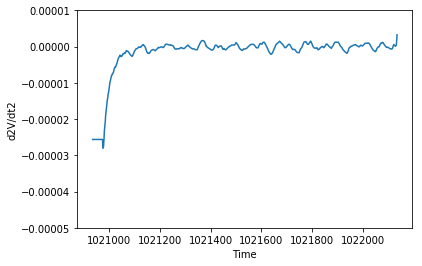

In [62]:
plt.plot(homemade['x_data'], homemade['d2ydx2'])
plt.xlabel('Time')
plt.ylabel('d2V/dt2')
plt.ylim(-5e-5,1e-5)

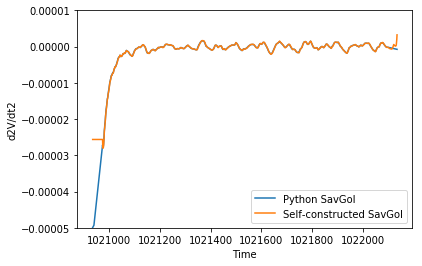

In [63]:
i = 39
s_filt = savgol_filter(x = d_trans[i]['Voltage/V'], window_length = 71, polyorder = 3, deriv = 2, delta = 1)
plt.plot(d_trans[i]['Time(s)'], s_filt, label = 'Python SavGol')
plt.plot(homemade['x_data'], homemade['d2ydx2'], label = 'Self-constructed SavGol')
plt.xlabel('Time')
plt.ylabel('d2V/dt2')
plt.ylim(-5e-5,1e-5)
plt.legend()

1194
1200.0


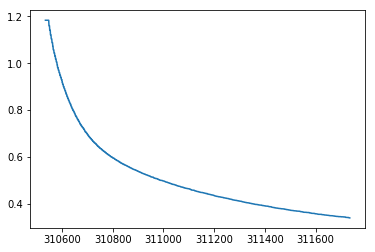

In [185]:
i = 2
plt.plot(d_trans[i]['Time(s)'], d_trans[i]['Voltage/V'])
#plt.plot(d_trans[i]['Time(s)'], d_trans[i]['Current/mA'])
print(len(d_trans[i]['Time(s)']))
print(d_trans[i]['Time(s)'][len(d_trans[i]['Time(s)'])-1] - d_trans[i]['Time(s)'][-0])